In [1]:
import os
memory = '10g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

In [2]:
from pyspark.ml.feature import Word2Vec
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import SQLContext
import pandas as pd
import nltk
from numpy.linalg import norm
import numpy as np
df = pd.read_csv('train.csv')

In [3]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [4]:
df['question1'][0]

'What is the step by step guide to invest in share market in india?'

In [5]:
# lets check for some null values..
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       2
is_duplicate    0
dtype: int64

In [6]:
df.dropna(how='any',axis=0,inplace=True)

In [7]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [8]:
print("Total number of questions",len(df))

Total number of questions 404288


In [9]:
df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [10]:
data_analysis = pd.Series(df['question1'].tolist() + df['question2'].tolist()).astype(str)

In [11]:
data_analysis[0:5]

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

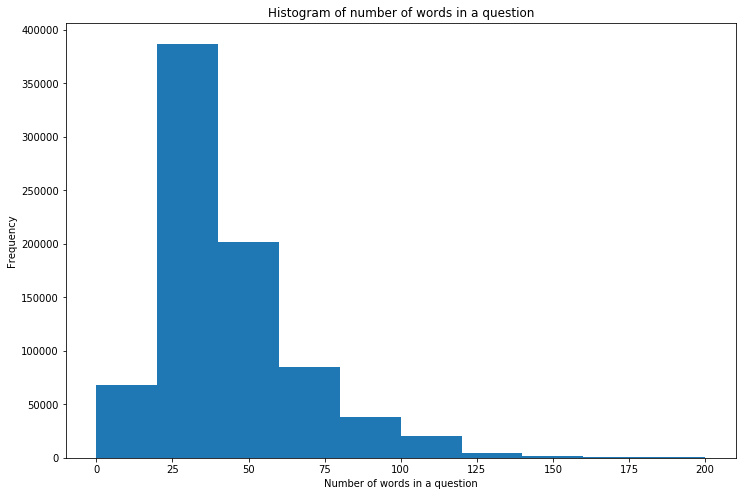

In [133]:
dist = data_analysis.apply(len)
plt.figure(figsize=(12,8))
plt.title("Histogram of number of words in a question")
plt.xlabel('Number of words in a question')
plt.ylabel('Frequency')
plt.hist(dist,range=[0,200])
plt.show()

(-0.5, 1299.5, 999.5, -0.5)

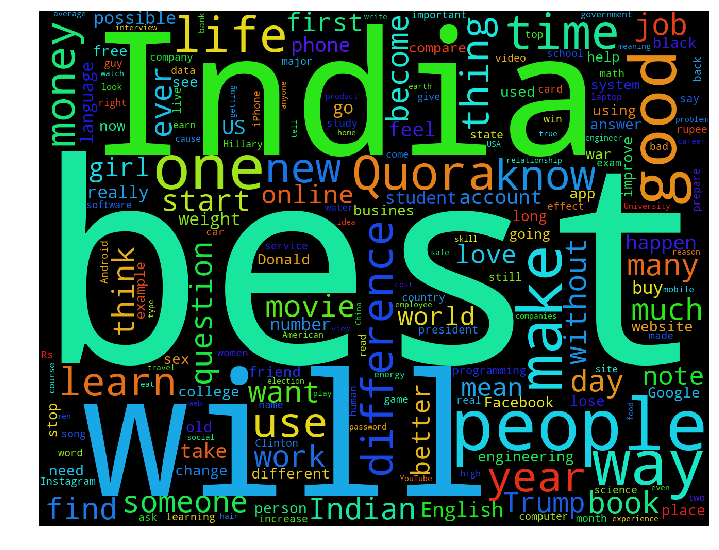

In [554]:
from wordcloud import WordCloud
cloud = WordCloud(width=1300, height=1000).generate(" ".join(data_analysis.astype(str)))
plt.figure(figsize=(12, 10))
plt.imshow(cloud)
plt.axis('off')

### Semantics

In [628]:
print("Number of questions having '?' = {:.2f}%".format(np.mean(data_analysis.apply(lambda x: '?' in x))*100))
print("Number of questions having '.' = {:.2f}%".format(np.mean(data_analysis.apply(lambda x: '.' in x))*100))
print("Number of questions having a number = {:.2f}%".format(np.mean(data_analysis.apply(lambda x: max([y.isdigit() for y in x])))*100))

Number of questions having '?' = 99.87%
Number of questions having '.' = 6.31%
Number of questions having a number = 11.83%


In [12]:
# data preprocessing done in python to make it easier for pyspark do work on :)
stopwords = nltk.corpus.stopwords.words()
import re
def clean(col):
    sent = re.compile('([^\s\w]|_)+').sub('', col).lower()
    sent = sent.split(" ")

    for w in sent:
        if w in stopwords:
            sent.remove(w)

    sent = " ".join(sent)
    return sent


df['question1'] = df['question1'].apply(clean)
df['question2'] = df['question2'].apply(clean)


In [13]:
df.head(4)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,is step step guide invest share market india,is step step guide invest share market,0
1,1,3,4,is story kohinoor kohinoor diamond,would happen indian government stole the kohin...,0
2,2,5,6,can increase speed my internet connection usin...,can internet speed increased hacking dns,0
3,3,7,8,am mentally lonely can solve,find remainder math2324math divided 2423,0


In [14]:
# made the document file in python(using df dataframe created before) 
# ( to save time :) )
documents = []

for i in range(0,len(df)):
    documents.append(df.iloc[i]['question1'])
    if(df.iloc[i]['is_duplicate']==0):        # using unique questions to not make training redundant on same questions
        documents.append(df.iloc[i]['question2'])

In [15]:
df.drop(['is_duplicate'],axis=1,inplace=True)

In [ ]:
# documents[0:2]

In [17]:
documents = [x.split() for x in documents]
documents[5]

['can', 'internet', 'speed', 'increased', 'hacking', 'dns']

In [18]:
# can use this to read the training file
# train = sqlContext.read.csv('train.csv',header = True,inferSchema = True)
sc = SparkContext('local')
sqlContext = SQLContext(sc)
train = sqlContext.createDataFrame(df)

In [19]:
train.show(4)

+---+----+----+--------------------+--------------------+
| id|qid1|qid2|           question1|           question2|
+---+----+----+--------------------+--------------------+
|  0|   1|   2|is step step guid...|is step step guid...|
|  1|   3|   4|is story kohinoor...|would happen indi...|
|  2|   5|   6|can increase spee...|can internet spee...|
|  3|   7|   8|am mentally lonel...|find remainder ma...|
+---+----+----+--------------------+--------------------+
only showing top 4 rows



In [20]:
from pyspark.sql.functions import isnan,count,when
train.select([count(when(isnan(c), c)).alias(c) for c in train.columns]).show()

+---+----+----+---------+---------+
| id|qid1|qid2|question1|question2|
+---+----+----+---------+---------+
|  0|   0|   0|        0|        0|
+---+----+----+---------+---------+



In [ ]:
# We can do this step but this takes a lot of time (using pyspark syntax)
"""
documents = []

for i in range(0,train.select('question1').count()):
    documents.append(train.collect()[i]['question1'])
    if(train.collect()[i]['is_duplicate']=='0'):
        documents.append(train.collect()[i]['question2'])
"""

In [20]:
"""
from pyspark.sql import Row
rdd1 = sqlContext.parallelize(documents)
row_rdd = rdd1.map(lambda x: Row(x))
"""

pd.DataFrame({'documents':documents})
df2=sqlContext.createDataFrame(pd.DataFrame({'documents':documents}))

In [21]:
df2.show(5)

+--------------------+
|           documents|
+--------------------+
|[is, step, step, ...|
|[is, step, step, ...|
|[is, story, kohin...|
|[would, happen, i...|
|[can, increase, s...|
+--------------------+
only showing top 5 rows



### Lets use Word2Vec !!

In [22]:
# Now lets apply Word2Vec
word2Vec = Word2Vec(vectorSize=100,windowSize=10, minCount=200, inputCol="documents", outputCol="result")
model = word2Vec.fit(df2)

In [23]:
result = model.transform(df2)

In [26]:
for row in result.collect()[0:3]:
    sentence, vector = row
    print("Sentence: [%s] => \nVector: %s\n" % (", ".join(sentence), str(vector)))

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'Word2Vec' object has no attribute '_java_obj'
Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/pyspark/ml/wrapper.py", line 40, in __del__
    

Sentence: [is, step, step, guide, invest, share, market, india] => 
Vector: [0.0818742960691452,0.1352273221127689,-0.06247943494236097,-0.10914855170994997,-0.19595806277357042,-0.19648136314935982,-0.10534135671332479,0.35443341435166076,0.12426456203684211,0.07455665752058849,-0.02792829438112676,0.16796494089066982,0.2093145006801933,0.039547330365167,0.19630261091515422,0.12626834865659475,-0.004686599597334862,-0.011669308529235423,-0.167632139287889,-0.04216541023924947,0.15394546458264813,-0.07585535943508148,-0.022493957309052348,0.0891863374854438,-0.09348013438284397,0.09886524238390848,-0.09733884315937757,-0.3494789395481348,0.1382706486620009,0.13007311522960663,-0.016432275297120214,-0.05879818648099899,0.10043670138111338,-0.03908898262307048,-0.040998848620802164,0.051089386688545346,-0.04075429419754073,-0.039847508538514376,0.13410601659779786,-0.09756129141896963,0.017554214224219322,-0.09717499790713191,-0.10871897265315056,-0.06651860103011131,0.009830094873905182

if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'Word2Vec' object has no attribute '_java_obj'


In [24]:
result.show(6)

+--------------------+--------------------+
|           documents|              result|
+--------------------+--------------------+
|[is, step, step, ...|[-0.0258020996116...|
|[is, step, step, ...|[-0.0443133823573...|
|[is, story, kohin...|[-0.0244293399155...|
|[would, happen, i...|[-0.0394877173006...|
|[can, increase, s...|[-0.1989977355115...|
|[can, internet, s...|[-0.1959825431307...|
+--------------------+--------------------+
only showing top 6 rows



In [26]:
model.getVectors().show(25)

+-------------+--------------------+
|         word|              vector|
+-------------+--------------------+
|     incident|[0.15706565976142...|
|      serious|[0.02947017177939...|
|     embedded|[-0.0043854531832...|
|      speaker|[-0.1458204835653...|
|         rate|[0.32507535815238...|
|         2014|[0.21890351176261...|
|           45|[-0.1518665105104...|
|         snow|[0.06463630497455...|
|      michael|[0.02391052804887...|
|        looks|[-0.0521396286785...|
|          4th|[-0.5105449557304...|
|   california|[-0.0821165964007...|
|     accident|[0.03092468343675...|
|      muscles|[-0.0798977687954...|
|   physically|[-0.2371650636196...|
|conversations|[0.19810788333415...|
|        ideas|[-0.1504241228103...|
|       liquid|[0.08924348652362...|
|      joining|[-0.2891990244388...|
| particularly|[-0.1773614585399...|
|         used|[-0.1108705326914...|
|          eye|[0.06833478808403...|
|      allowed|[-0.0021459464915...|
|    reference|[-0.0927777811884...|
|

In [29]:
"""
filename = 'stored_model.wv' # Can be any arbitrary filename
model.save(filename) 
"""

In [52]:
ind = np.random.randint(0,model.getVectors().count()+1)
print('Word = {} '.format(model.getVectors().collect()[ind]['word']))
max_test = -100000000000000

for i in range(0,len(model.getVectors().collect())):
    if(i!=ind):
        cosine_sim = np.dot(model.getVectors().collect()[i]['vector'],model.getVectors().collect()[ind]['vector'])/((norm(model.getVectors().collect()[i]['vector']))*(norm(model.getVectors().collect()[ind]['vector'])))        
        if(cosine_sim>max_test):
            max_test = cosine_sim
            sim_word_test = model.getVectors().collect()[i]['word']
            
print('Most Similar Word = {}'.format(sim_word_test))    

Word = printer 
Most Similar Word = hp


In [41]:
res = model.findSynonyms('incident',3) # return 3 "synonyms"
res.show(3)

+---------+------------------+
|     word|        similarity|
+---------+------------------+
|   moment|0.6596916317939758|
|  moments|0.5998780131340027|
|childhood|0.5727454423904419|
+---------+------------------+



In [45]:
res = model.findSynonyms('beautiful',5) # return 5 "synonyms"
res.show(5)

+----------+------------------+
|      word|        similarity|
+----------+------------------+
|attractive|0.5898951888084412|
|     funny|0.5681017637252808|
|    beauty|0.5634511709213257|
|underrated|0.5537212491035461|
|   awesome|0.5526648163795471|
+----------+------------------+



In [46]:
res = model.findSynonyms('car',5) # return 5 "synonyms"
res.show(5)

+-------+------------------+
|   word|        similarity|
+-------+------------------+
|   cars|0.7503092288970947|
|  wheel|0.6885342597961426|
|   ride|0.6587249040603638|
|   bike| 0.658012330532074|
|vehicle| 0.654242753982544|
+-------+------------------+



In [ ]:
# So you can actually tag the questions with a word and find similar questions by finding the questions which have
# the synonymous tags

In [143]:
type(model.getVectors().select('vector'))

+--------------------+
|              vector|
+--------------------+
|[0.16988040506839...|
|[-0.1837505251169...|
+--------------------+
only showing top 2 rows



NoneType

In [361]:
# .transform method
p = [['snow']]
print(model.transform(sqlContext.createDataFrame(pd.DataFrame([res_word],columns=['documents']))).collect()[0][1])

[-0.07466133683919907,0.2635296583175659,0.03382672742009163,0.2153698205947876,0.26321572065353394,0.19767826795578003,0.024400832131505013,0.10512962937355042,-0.07421072572469711,0.0075380741618573666,0.34349945187568665,-0.36908528208732605,-0.27458861470222473,-0.05353272706270218,0.4964402914047241,0.010587530210614204,-0.16596823930740356,-0.23092319071292877,0.06271348148584366,-0.1126525029540062,-0.21491681039333344,0.08903124183416367,0.02798421122133732,-0.03838581591844559,0.045961763709783554,-0.2182745784521103,-0.12445288151502609,-0.3983164131641388,0.05603325366973877,-0.29980817437171936,0.004810095764696598,-0.11516553908586502,-0.17039737105369568,0.1774015575647354,0.012232450768351555,0.4874473810195923,0.06703566014766693,0.28657349944114685,0.5582836270332336,-0.13123057782649994,-0.34068942070007324,-0.13045968115329742,-0.1780751794576645,-0.040764763951301575,0.495950847864151,0.04393470659852028,-0.13326537609100342,-0.261738121509552,-0.39681142568588257,0

### Using PCA to decrease the dimensionality of vectors

In [54]:
from pyspark.ml.feature import PCA
pca = PCA(k=3, inputCol="vector", outputCol="pcaFeatures")
model_pca = pca.fit(model.getVectors().select('vector'))

result_pca = model_pca.transform(model.getVectors().select('vector')).select("pcaFeatures")

In [139]:
print("Word = {0} and its representation = {1}".format(model.getVectors().collect()[0][0],model.getVectors().collect()[0]['vector']))
print()
print("Word = {0} and its PCA representation = {1}".format(model.getVectors().collect()[0][0],result_pca.collect()[0]['pcaFeatures']))

Word = incident and its representation = [0.15706565976142883,0.06711146235466003,-0.08294181525707245,-0.3025716245174408,-0.28888267278671265,-0.616371214389801,-0.30569466948509216,-0.024195021018385887,-0.11543864011764526,-0.06305581331253052,0.25957098603248596,-0.10166414082050323,0.13632053136825562,0.030745381489396095,0.0792156234383583,0.5676795244216919,0.08982932567596436,-0.06298629939556122,-0.3663630187511444,-0.20902207493782043,-0.17246180772781372,0.29024043679237366,0.1455729603767395,-0.48097142577171326,-0.1816185563802719,0.03555629774928093,-0.18250221014022827,0.07684614509344101,0.07048959285020828,-0.0719909518957138,-0.2356393188238144,-0.44632744789123535,0.020875204354524612,0.17501342296600342,0.4831019937992096,-0.22527357935905457,-0.3422291874885559,-0.09828032553195953,0.2611093819141388,0.010137075558304787,-0.11620756983757019,-0.014132685959339142,-0.017760325223207474,0.11344199627637863,0.1371573507785797,-0.32587286829948425,0.3763252794742584,0

In [55]:
result_pca.show(1)

+--------------------+
|         pcaFeatures|
+--------------------+
|[0.65977088568268...|
+--------------------+
only showing top 1 row



In [160]:
result_pca.collect()[0][0]

DenseVector([0.6446, 0.1481, 0.2543])

In [201]:
model.getVectors().count()

3074

In [202]:
result_pca.count()

3074

In [229]:
from sklearn.manifold import TSNE

In [105]:
res = model.findSynonyms('phone',5) # return 5 "synonyms"
res.show(5)

+----------+------------------+
|      word|        similarity|
+----------+------------------+
|    mobile|0.7708603739738464|
|    phones|0.7286869287490845|
|    device|0.6977419257164001|
|smartphone|0.6695911288261414|
| antivirus|0.6474941968917847|
+----------+------------------+



In [106]:
res.count()

5

In [107]:
pca2 = PCA(k=2, inputCol="vector", outputCol="pcaFeatures2D")
model_pca2 = pca2.fit(model.getVectors().select('vector'))

result_pca2 = model_pca2.transform(model.getVectors().select('vector')).select("pcaFeatures2D")

In [136]:
result_pca2.show(5)

+--------------------+
|       pcaFeatures2D|
+--------------------+
|[0.65977088568268...|
|[0.53021994564132...|
|[-1.1410495880768...|
|[-0.0649132110454...|
|[-0.3632829014518...|
+--------------------+
only showing top 5 rows



In [108]:
arr = []
word_labels = []
close_word = 'phone'
for j in range(0,model.getVectors().count()):
    if((model.getVectors().collect()[j][0])==close_word):
        word_labels.append(np.asarray(model.getVectors().collect()[j][0]))
        arr.append(np.asarray(result_pca2.collect()[j][0]))
        break

In [109]:
for i in range(0,res.count()):
    close_word = res.collect()[i][0]
    for j in range(0,model.getVectors().count()):
        if((model.getVectors().collect()[j][0])==close_word):
            word_labels.append(np.asarray(model.getVectors().collect()[j][0]))
            arr.append(np.asarray(result_pca2.collect()[j][0]))
            break
            
            
# or you can also use .transform method
"""
for i in range(0,res.count()):
    res_word = [[res.collect()[i][0]]]
    print(model.transform(sqlContext.createDataFrame(pd.DataFrame([res_word],columns=['documents']))).collect()[0][1])
    word_labels.append(np.asarray(res_word))
    arr.append(np.asarray(model.transform(sqlContext.createDataFrame(pd.DataFrame([res_word],columns=['documents']))).collect()[0][1]))
 
"""                

"\nfor i in range(0,res.count()):\n    res_word = [[res.collect()[i][0]]]\n    print(model.transform(sqlContext.createDataFrame(pd.DataFrame([res_word],columns=['documents']))).collect()[0][1])\n    word_labels.append(np.asarray(res_word))\n    arr.append(np.asarray(model.transform(sqlContext.createDataFrame(pd.DataFrame([res_word],columns=['documents']))).collect()[0][1]))\n \n"

In [92]:
"""
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)
"""

'\ntsne = TSNE(n_components=2, random_state=0)\nnp.set_printoptions(suppress=True)\nY = tsne.fit_transform(arr)\n'

In [116]:
xcoordinate = []
ycoordinate = []
for i in range(0,len(arr)):
    xcoordinate.append(arr[i][0])
    ycoordinate.append(arr[i][1])    

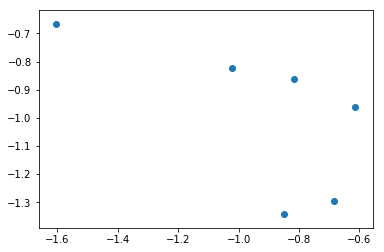

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline 
"""
x_coords = Y[:, 0]
y_coords = Y[:, 1]
plt.scatter(x_coords, y_coords)
"""
# display scatter plot
plt.scatter(xcoordinate, ycoordinate)


In [125]:
xcoordinate = np.asarray(xcoordinate)

In [126]:
ycoordinate = np.asarray(ycoordinate)

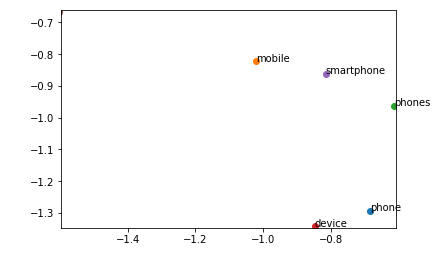

In [131]:
"""
for label, x, y in zip(word_labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.scatter(x, y)

plt.xlim(x_coords.min()+0.005, x_coords.max()+0.005)
plt.ylim(y_coords.min()+0.005, y_coords.max()+0.005)
plt.show()
"""

for label, x, y in zip(word_labels, xcoordinate, ycoordinate):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.scatter(x, y)

plt.xlim(xcoordinate.min()+0.007, xcoordinate.max()+0.005)
plt.ylim(ycoordinate.min()-0.005, ycoordinate.max()+0.005)
plt.show()



### Getting some Analogies 

In [397]:
# do we see some relation between the maths of the word vectors ??
p = [['mobile']]
q = [['phone']]
r = [['student']]

In [398]:
# qry = wordvector(q) - wordvector(p) - wordvector(r)
qry = model.transform(sqlContext.createDataFrame(pd.DataFrame([q],columns=['documents']))).collect()[0][1] - model.transform(sqlContext.createDataFrame(pd.DataFrame([p],columns=['documents']))).collect()[0][1] - model.transform(sqlContext.createDataFrame(pd.DataFrame([r],columns=['documents']))).collect()[0][1]

In [415]:
analogy_result = model.findSynonyms(qry,num=5)
word_list = []
for i in range(0,analogy_result.count()):
    word_list.append(analogy_result.collect()[i][0])

word_list_copy = word_list.copy()    
for i in range(0,len(word_list_copy)):
    if word_list_copy[i]==p[0][0] or word_list_copy[i]==q[0][0] or word_list_copy[i]==r[0][0]:
        word_list.remove(word_list[i])

print('Analogies =',word_list)

Analogies = ['accidentally', 'lying', 'dead', 'died']


In [ ]:
# Probably some relation with students meeting with accident using phone while driving
# accidently could refer to accidently dropping the phone

In [457]:
"""
#from numpy.linalg import norm
#norm(result_pca.collect()[0][0] - result_pca.collect()[1][0])

# finding most similar question to question1 using cosine similarity score (in result_pca)
import sys
m = float('-inf')
for i in range(0,result_pca.count()):
    cosine_sim = np.dot(result_pca.collect()[0][0],result_pca.collect()[i][0])/((norm(result_pca.collect()[0][0]))*(norm(result_pca.collect()[i][0])))
    if(cosine_sim>m and i!=0):
        m = cosine_sim
        similar_question = result.select('documents').collect()[i]
"""        

In [458]:
"""
print('Question',result.select('documents').collect()[0])
print('Similar Question',similar_question)

# probably we don't have enough similar questions in the dataset other than the provided similar question
"""

Question Row(documents=['is', 'step', 'step', 'guide', 'invest', 'share', 'market', 'india'])
Similar Question Row(documents=['is', 'meant', 'c', 'language'])


### Lets Test !!

In [25]:
df_test = pd.read_csv('test.csv')

In [26]:
df_test.head(3)

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?


In [27]:
df_test.isnull().sum()

test_id      0
question1    2
question2    4
dtype: int64

In [28]:
df_test.dropna(how='any',axis=0,inplace=True)

In [29]:
df_test.isnull().sum()

test_id      0
question1    0
question2    0
dtype: int64

In [30]:
df_test = df_test[0:15] 

In [31]:
df_test['question1'] = df_test['question1'].apply(clean)
df_test['question2'] = df_test['question2'].apply(clean)

In [32]:
df_test.head(3)

,test_id,question1,question2
0,0,does surface pro 4 compare ipad pro,did microsoft choose core m3 not core i3 home ...
1,1,i a hair transplant age 24 much would cost,much cost hair transplant require
2,2,but the best way send money china the us,you send money china


In [33]:
documents_test = []

for i in range(0,len(df_test)):
    documents_test.append(df_test.iloc[i]['question1'])
    documents_test.append(df_test.iloc[i]['question2'])

In [34]:
documents_test[0:5]

['does surface pro 4 compare ipad pro',
 'did microsoft choose core m3 not core i3 home surface pro 4',
 'i a hair transplant age 24 much would cost',
 'much cost hair transplant require',
 'but the best way send money china the us']

In [35]:
documents_test = [x.split() for x in documents_test]
documents_test

[['does', 'surface', 'pro', '4', 'compare', 'ipad', 'pro'],
 ['did',
  'microsoft',
  'choose',
  'core',
  'm3',
  'not',
  'core',
  'i3',
  'home',
  'surface',
  'pro',
  '4'],
 ['i', 'a', 'hair', 'transplant', 'age', '24', 'much', 'would', 'cost'],
 ['much', 'cost', 'hair', 'transplant', 'require'],
 ['but', 'the', 'best', 'way', 'send', 'money', 'china', 'the', 'us'],
 ['you', 'send', 'money', 'china'],
 ['food', 'emulsifiers'],
 ['foods', 'fibre'],
 ['aberystwyth', 'start', 'reading'],
 ['their', 'i', 'start', 'reading'],
 ['are', 'two', 'wheeler', 'insurance', 'bharti', 'axa', 'insurance'],
 ['admire', 'am', 'considering', 'buying', 'insurance', 'them'],
 ['can', 'reduce', 'belly', 'fat', 'a', 'diet'],
 ['can', 'reduce', 'lower', 'belly', 'fat', 'one', 'month'],
 ['scrapping',
  '500',
  '1000',
  'rupee',
  'notes',
  'is',
  'rbi',
  'planning',
  'fight',
  'issue',
  'black',
  'money'],
 ['recent',
  'move',
  'declare',
  '500',
  '1000',
  'denomination',
  'lewin',
  'i

In [36]:
pd.DataFrame({'documents':documents_test})
df2_test=sqlContext.createDataFrame(pd.DataFrame({'documents':documents_test}))

In [37]:
df2_test.show(2)

+--------------------+
|           documents|
+--------------------+
|[does, surface, p...|
|[did, microsoft, ...|
+--------------------+
only showing top 2 rows



In [38]:
result_test = model.transform(df2_test)

In [39]:
result_test.collect()[0][1]

DenseVector([-0.1251, -0.3238, 0.1354, 0.2108, 0.0398, 0.0207, -0.0609, 0.2348, 0.1606, -0.2812, 0.0501, -0.4497, -0.0583, 0.2359, 0.228, -0.1523, 0.2774, -0.3083, -0.0459, 0.0256, -0.0948, 0.0821, 0.1753, -0.0255, -0.0102, -0.0984, 0.1838, -0.2003, 0.1764, 0.044, 0.0633, -0.1103, 0.0138, 0.0797, 0.2571, 0.3594, -0.1814, -0.4786, -0.2406, 0.1439, 0.1895, 0.1242, 0.2592, -0.3771, 0.0786, -0.0546, -0.1488, -0.3846, -0.0524, 0.1423, 0.1451, -0.2733, -0.37, -0.258, -0.0186, -0.0811, -0.0789, 0.0839, -0.1019, 0.041, -0.1217, 0.3008, -0.0384, 0.0791, -0.1755, 0.0148, -0.16, -0.0487, 0.2047, -0.1129, -0.074, -0.3963, -0.1185, 0.0606, -0.2108, 0.3314, 0.0245, -0.3209, 0.0805, 0.0989, 0.1283, 0.0397, 0.2733, -0.303, -0.1997, -0.1102, -0.0855, -0.2114, 0.0133, -0.3569, -0.0784, 0.1167, 0.2585, -0.0391, 0.244, -0.2385, 0.0806, -0.1314, 0.2557, -0.0377])

In [634]:
k = 0
for i in range(0,result_test.count()-1,2):
    cosine_sim = np.dot(result_test.collect()[i][1],result_test.collect()[i+1][1])/((norm(result_test.collect()[i][1]))*(norm(result_test.collect()[i+1][1])))        
    print('Question 1',test_report['question1'].iloc[k])
    print('Question 2',test_report['question2'].iloc[k])  
    print('Cosine_Sim',cosine_sim)
    k+=1
    if(cosine_sim>0.7):
        print('Similar')
    else:
        print('Not Similar')
    print()

Question 1 How does the Surface Pro himself 4 compare with iPad Pro?
Question 2 Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?
Cosine_Sim 0.7359112922209852
Similar

Question 1 Should I have a hair transplant at age 24? How much would it cost?
Question 2 How much cost does hair transplant require?
Cosine_Sim 0.7938762579683857
Similar

Question 1 What but is the best way to send money from China to the US?
Question 2 What you send money to China?
Cosine_Sim 0.7751495033656934
Similar

Question 1 Which food not emulsifiers?
Question 2 What foods fibre?
Cosine_Sim 0.5068020237049685
Not Similar

Question 1 How "aberystwyth" start reading?
Question 2 How their can I start reading?
Cosine_Sim 0.797250456521179
Similar

Question 1 How are the two wheeler insurance from Bharti Axa insurance?
Question 2 I admire I am considering of buying insurance from them
Cosine_Sim 0.6301503770157117
Not Similar

Question 1 How can I reduce my belly fat through a diet?
Question 2 How